In [9]:
# Import neccessary packages

import tensorflow as tf
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
#epochs and size of NN is defined

EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'D:/New Plant Diseases Dataset'
width = 256
height = 256
depth = 3

In [2]:
# Function to convert images to array

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)  #cv2 used as keword for OpenCV Library already imported in main code
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
# Fetch images from directory
    
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:50]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bel

In [7]:
# Get Size of Processed Image and Transform Image Labels uisng Scikit Learn's LabelBinarizer and print classes 

image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper__bell___Bacterial_spot'
 'Pepper__bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

In [6]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()


[INFO] Spliting data to train, test







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)   

In [7]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] training network...
Epoch 1/25
47/47 [==============================] - 407s 9s/step - loss: 0.1130 - acc: 0.9725 - val_loss: 0.2069 - val_acc: 0.9634
Epoch 2/25
47/47 [==============================] - 394s 8s/step - loss: 0.1016 - acc: 0.9720 - val_loss: 0.3227 - val_acc: 0.9544
Epoch 3/25
47/47 [==============================] - 356s 8s/step - loss: 0.0977 - acc: 0.9726 - val_loss: 0.2702 - val_acc: 0.9580
Epoch 4/25
47/47 [==============================] - 365s 8s/step - loss: 0.0864 - acc: 0.9745 - val_loss: 0.1719 - val_acc: 0.9641
Epoch 5/25
47/47 [==============================] - 366s 8s/step - loss: 0.0742 - acc: 0.9771 - val_loss: 0.2738 - val_acc: 0.9577
Epoch 6/25
47/47 [==============================] - 373s 8s/step - loss: 0.0821 - acc: 0.9749 - val_loss: 0.2591 - val_acc: 0.9577
Epoch 7/25
47/47 [==============================] - 411s 9s/step - loss: 0.0710 - acc: 0.977

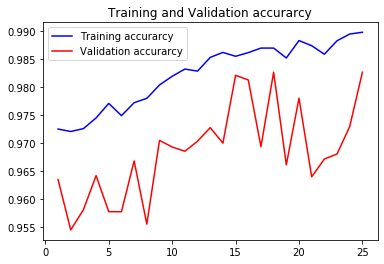

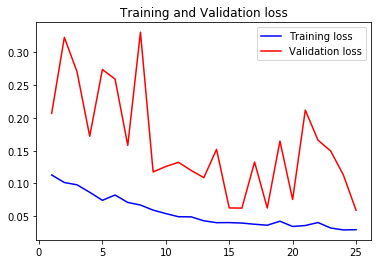

In [8]:
# Plot the train and val curve

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [9]:
# Model Accuracy

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
380/380 [==============================] - 22s 57ms/step
Test Accuracy: 98.2617769743267


In [10]:
# save the model to disk

print("[INFO] Saving model...")
from keras.models import load_model
model.save('newdatasetmodel.h5')

[INFO] Saving model...


In [11]:
from keras.models import load_model
model = load_model('C:/Users/NIKHIL/Desktop/del/Projects-master/newdatasetmodel.h5')

# Mention name of the disease into list.
Classes = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
           'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot',
 'Peach___healthy', 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight',
 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' ,'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']


In [17]:

arr = model.predict_classes(x_test[25:30])
print(arr)
for i in arr:
    a = Classes[i]
    print(a)
    if a=='Pepper__bell___Bacterial_spot':
        print()
        print("Treatment:",'A plant with bacterial spot cannot be cured.  Remove symptomatic plants from the field or greenhouse to prevent the spread of bacteria to healthy plants.  Burn, bury or hot compost the affected plants .Spray every 10-14 days with fixed copper (organic fungicide) to slow down the spread of infection.')
    elif a=='Pepper__bell___healthy':
        pass
    elif a=='Potato___Early_blight':
        print()
        print("Treatment:",'For best control, apply copper-based fungicides early like liquid copper, two weeks before disease normally appears or when weather forecasts predict a long period of wet weather. Alternatively, begin treatment when disease first appears, and repeat every 7-10 days for as long as needed.Burn or bag infected plant parts. Do NOT compost.')
    elif a=='Potato___Late_blight':
        print()
        print("Treatment:",'Safely treat fungal problems with SERENADE Garden. This broad spectrum bio-fungicide uses a patented strain of Bacillus subtilis and is approved for organic use. Best of all, SERENADE is completely non-toxic to honey bees and beneficial insects.')
    elif a=='Potato___healthy':
        pass
    elif a=='Tomato_Bacterial_spot':
        print()
        print("Treatment:",'A plant with bacterial spot cannot be cured.  Remove symptomatic plants from the field or greenhouse to prevent the spread of bacteria to healthy plants.  Burn, bury or hot compost the affected plants.to prevent spread, DO NOT handle plants when they are wet (e.g., from dew) and routinely sterilize tools with either 10% bleach solution or (better) 70 percent alcohol (e.g., rubbing alcohol).  Where bacterial spot has been a recurring problem, consider using preventative applications of copper-based products registered for use on tomato, especially during warm, wet periods. ')
    elif a=='Tomato_Early_blight':
        print()
        print("Treatment:",'For best control, apply copper-based fungicides early like liquid copper, two weeks before disease normally appears or when weather forecasts predict a long period of wet weather. Alternatively, begin treatment when disease first appears, and repeat every 7-10 days for as long as needed.Burn or bag infected plant parts. Do NOT compost.')
    elif a=='Tomato_Late_blight':
        print()
        print("Treatment:",'Safely treat fungal problems with SERENADE Garden. This broad spectrum bio-fungicide uses a patented strain of Bacillus subtilis and is approved for organic use. Best of all, SERENADE is completely non-toxic to honey bees and beneficial insects.')
    elif a=='Tomato_Leaf_Mold':
        print()
        print("Treatment:",'Minimize long periods of leaf wetness by avoiding wetting the foliage and the use of fans to circulate air.Staking and pruning to increase ventilation reduces disease spread.Maintain night temperatures in the greenhouse higher than outside temperatures.Fungicides effectively control this disease.')
    elif a=='Tomato___Septoria_leaf_spot':
        print()
        print("Treatment:",'Remove infected leaves immediately, and be sure to wash your hands thoroughly before working with uninfected plants.Fungicides containing either copper or potassium bicarbonate will help prevent the spreading of the disease. Begin spraying as soon as the first symptoms appear and follow the label directions for continued management.One of the least toxic and most effective chemical fungicide that can be used here is chlorothalonil (sold under the names Fungonil and Daconil).')
    elif a=='Tomato_Spider_mites_Two_spotted_spider_mite':
        print()
        print("Treatment:",'bifenazate (Acramite): Group UN, a long residual nerve poison,abamectin (Agri-Mek): Group 6, derived from a soil bacterium,spirotetramat (Movento): Group 23, mainly affects immature stages,spiromesifen (Oberon 2SC): Group 23, mainly affects immature stages,insecticidal soap (M-Pede),neem oil (Trilogy),soybean oil (Golden Pest Spray Oil).')	
    elif a=='Tomato__Target_Spot':
        print()
        print("Treatment:",'The products to use are chlorothalonil, copper oxychloride or mancozeb. Treatment should start when the first spots are seen.')
    elif a=='Tomato__Tomato_YellowLeaf__Curl_Virus':
        print()
        print("Treatment:",'Use a neonicotinoid insecticide, such as dinotefuran (Venom) imidacloprid (AdmirePro, Alias, Nuprid, Widow, and others) or thiamethoxam (Platinum), as a soil application or through the drip irrigation system at transplanting of tomatoes.Prevent the spread of any whiteflies to healthy plants.')
    elif a=='Tomato__Tomato_mosaic_virus':
        print()
        print("Treatment:",'There are no cures for viral diseases such as mosaic once a plant is infected. As a result, every effort should be made to prevent the disease from entering your garden.Treat the spot with least-toxic, natural pest control products, such as Safer Soap, Bon-Neem to reduce the number of disease carrying insects.Remove all perennial weeds, using least-toxic herbicides, within 100 yards of your garden plot.Remove and destroy all infected plants but do NOT compost.')
    elif a=='Tomato_healthy':
        pass
    print()
    print("*********************************************************************************************************************")
    print()

[10  2  3 32 22]
Corn_(maize)___healthy

*********************************************************************************************************************

Apple___Cedar_apple_rust

*********************************************************************************************************************

Apple___healthy

*********************************************************************************************************************

Tomato___Septoria_leaf_spot

Treatment: Remove infected leaves immediately, and be sure to wash your hands thoroughly before working with uninfected plants.Fungicides containing either copper or potassium bicarbonate will help prevent the spreading of the disease. Begin spraying as soon as the first symptoms appear and follow the label directions for continued management.One of the least toxic and most effective chemical fungicide that can be used here is chlorothalonil (sold under the names Fungonil and Daconil).

**************************************

In [10]:
from keras.models import load_model
model = load_model('C:/Users/NIKHIL/Desktop/del/Projects-master/newdatasetmodel.h5')

# Mention name of the disease into list.
Classes = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
           'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy' ,'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot',
 'Peach___healthy', 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight',
 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy',
 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch',
 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight',
 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' ,'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [11]:
import numpy as np
import cv2

default_image_size = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)  #cv2 used as keyword for OpenCV Library already imported in main code
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [13]:

imgpath = 'D:/Original Plant Diseases Dataset(Augmented)/train/Soybean___healthy/6033b6c1-a12a-4c11-9e19-d7ec164b151c___RS_HL 3916.JPG'
# imgpath = 'C:/Users/NIKHIL/Desktop/del/Projects-master/PlantVillage/Pepper/Pepper__bell___Bacterial_spot/0fcbdf76-fcc4-4271-986a-9466a784d404___JR_B.Spot 3374.JPG'

imar = convert_image_to_array(imgpath)
print(imar)
print("*************************************************")
np_image_list = np.array([imar], dtype=np.float16) / 225.0 
arr = model.predict_classes(np_image_list) 
print(arr)

for i in arr:
    a = Classes[i]
    print(a)
    if a=='Apple___Apple_scab':
        print()
        print("Symptoms:",'Yellow or chlorotic spots on leaves; severely infected leaves turn yellow and drop from tree.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Remove all leaves dropped from tree in the fall and compost to prevent any diseases surviving in debris; application of zinc and fertilizer grade urea in the Fall may be necessary to speed leaf drop, lime should then be added to fallen leaves; fungicide application may be necessary in areas where leaves remain wet for periods in excess of 9 hours; fungicides such as copper soaps and Bordeaux mixture should be applied if there is a chance of wet period as soon as leaf tips emerge.')
    elif a=='Apple___Black_rot':
        print()
        print("Symptoms:",' Red flecks, purple lesions and/or brown black rings on fruit.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Remove dead wood, mummify fruit and cankers from trees to reduce spread of disease; burn any prunings that have been made from the tree; disease can be controlled by applying fungicides from silver tip to harvest.')
    elif a=='Apple___Cedar_apple_rust':
        print()
        print("Symptons:",'Bright orange or yellow patches on top side of leaves surrounded by a red band and small black spots in the center.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Plant resistant varieties where possible; remove nearby red cedar; if growing susceptible varieties in proximity to red cedar follow a fungicide program.')
    elif a=='Apple___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Blueberry___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Cherry_(including_sour)___Powdery_mildew':
        print()
        print("Symptons:",'Light colored circular lesions on leaves inside tree canopy which develop a powdery appearance; lesions may coalesce to cover leaf; if infection is severe, leaves may blister.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Cultural practices which promote good air circulation around tree canopies to lower humidity. Also using some appropriate fungicides.')
    elif a=='Cherry_(including_sour)___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot':
        print()
        print("Symptons:",'Brown Spots with yellow rings throughout the leaf during the growing period of the Cassava. Lesions that are 0.15-0.2 cm in diameter. Serious cases can lead to holes throughout the lesions on the leaf.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Plant corn hybrids with resistance to the disease; crop rotation and plowing debris into soil may reduce levels of inoculum in the soil but may not provide control in areas where the disease is prevalent; foliar fungicides may be economically viable for some high yeilding susceptible hybrids.')
    elif a=='Corn_(maize)___Common_rust_':
        print()
        print("Symptons:",'Oval or elongated cinnamon brown pustules on upper and lower surfaces of leaves; pustules rupture and release powdery red spores; pustules turn dark brown-black as they mature and release dark brown powdery spores; if infection is severe, pustules may appear on tassels.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'The most effective method of controlling the disease is to plant resistant hybrids; application of appropriate fungicides may provide some degree on control and reduce disease severity.')
    elif a=='Corn_(maize)___Northern_Leaf_Blight':
        print()
        print("Symptons:",'In the beginning we will notice elliptical gray-green lesions on leaves. As the disease process this lesions become pale gray to tan color. Later stage the lesions looks dirty due to dark gray spores particularly under lower leaf surface.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Follow proper tillage to reduce fungus inoculum from crop debris. Follow crop rotation with non host crop. Grow available resistant varieties. In severe case of disease incidence apply suitable fungicide.')
    elif a=='Corn_(maize)___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Grape___Black_rot':
        print()
        print("Symptons:",'Brown lesions on the leaves that develop black dots (pycnidia); grapes have light spots that eventually form pycnidia; grapes harden and turn black.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Remove all mummified fruit from vines during dormant pruning; cultivate soil during bud break to bury mummies and reduce inoculant; application of appropriate fungicides can help control the disease.')
    elif a=='Grape___Esca_(Black_Measles)':
        print()
        print("Symptons:",'Symptom appears on leaves, trunk, canes and berries. On leaves we will see intervenaial striping looks like tiger strips. On berries we will see superficial spots and later may coalesce making berries appear black.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Remove the infected berries, leaves and trunk and destroy them. Protect the prune wounds to minimize fungal infection using wound sealant (5% boric acid in acrylic paint) or essential oil or suitable fungicides.')
    elif a=='Grape___Leaf_blight_(Isariopsis_Leaf_Spot)':
        print()
        print("Symptons:",'On leaf surface we will see lesions which are irregularly shaped (2 to 25 mm in diameter). Initially lesions are dull red to brown in color turn black later. If disease is severe this lesions may coalesce. On berries we can see symptom similar to black rot but the entire clusters will collapse.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Fungicides sprayed for other diseases in the season may help to reduce this disease.')
    elif a=='Grape___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Orange___Haunglongbing_(Citrus_greening)':
        print()
        print("Symptons:",'Leaf symptoms of citrus greening include yellowing of one limb or one area of canopy, yellowing of leaf veins. Fruits may drop prematurely and are often mishappen and lopsided; fruit has a bitter, salty taste.')
        print()
        print("Cause:",'Bacteria')
        print()
        print("Treatment:",'Preventing the disease occurring in the first place and this is achieved through strict quarantining to prevent the introduction of citrus psyllids to areas which are currently free of the pest. Areas which are subject to quarantine have restrictions placed on the movement of citrus plants, fruit, equipment and items made from citrus. Infected trees should be removed as quickly as possible from plantations and destroyed.')
    elif a=='Peach___Bacterial_spot':
        print()
        print("Symptons:",'Water soaked, angular gray lesions on the underside of the leaves which turn purple and necrotic in the center and cause a shot hole appearance if lesion center drops out. Lesions on fruit begin as small brown, water-soaked lesions which may exude gum')
        print()
        print("Cause:",'Bacterium')
        print()
        print("Treatment:",'Avoid planting susceptible peach varieties in areas where disease is known. Protective copper applications in the Fall prior to leaf drop and/or application in early growing season may help prevent the disease; care should be taken as peach trees are very sensitive to copper.')
    elif a=='Peach___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Pepper__bell___Bacterial_spot':
        print()
        print("Symptons:",'Water-soaked lesions that dry out and turn brown forming on the underside of the leaves; raised brown cankers on stems; cracked brown lesions on fruit.')
        print()
        print("Cause:",'Bacterium')
        print()
        print("Treatment:",'A plant with bacterial spot cannot be cured. Remove symptomatic plants from the field or greenhouse to prevent the spread of bacteria to healthy plants. Burn, bury or hot compost the affected plants. Spray every 10-14 days with fixed copper (organic fungicide) to slow down the spread of infection.')
    elif a=='Pepper__bell___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Potato___Early_blight':
        print()
        print("Symptons:",'Dark lesions with yellow border which may form concentric rings of raised and sunken tissue on the leaves and stems; lesions initially circular but become angular.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'For best control, apply copper-based fungicides early like liquid copper, two weeks before disease normally appears or when weather forecasts predict a long period of wet weather. Alternatively, begin treatment when disease first appears, and repeat every 7-10 days for as long as needed.Burn or bag infected plant parts. Do NOT compost.')
    elif a=='Potato___Late_blight':
        print()
        print("Symptons:",'Irregularly shaped spreading brown lesions on leaves with distinctive white fluffy sporulation at lesion margins on the underside of the leaf in wet conditions. In dry condition the lesions dry up and go dark brown with collapsed tissue.')
        print()
        print("Cause:",'Oomycete')
        print()
        print("Treatment:",'Safely treat fungal problems with SERENADE Garden. This broad spectrum bio-fungicide uses a patented strain of Bacillus subtilis and is approved for organic use. Best of all, SERENADE is completely non-toxic to honey bees and beneficial insects.')
    elif a=='Potato___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Raspberry___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Soybean___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Squash___Powdery_mildew':
        print()
        print("Symptoms:",'White powdery growth on the upper surfaces of leaves and stems; infected areas stunted and distorted.')
        print()
        print("Cause:",'Fungi')
        print()
        print("Treatment:",'Plant in sites with good air circulation and sun exposure; do not overcrowd plants; sanitize equipment regularly.')
    elif a=='Strawberry___Leaf_scorch':
        print()
        print("Symptoms:",'Irregular dark purple or brown blotches on upper leaf surface which may colaesce to produce large purplish brown patches; tissue between blotches may turn purple or red; lesions may girdle peduncles causing death of fruit.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Plant resistant varieties; regular renewal of plants; plant in an area with good air circulation and drainage in full sun; remove all foliage from plants at harvest; application of appropriate foliar fungicide may be required to provide control.')
    elif a=='Strawberry___healthy':
        print()
        print("Plant is healthy.")
    elif a=='Tomato___Bacterial_spot':
        print()
        print("Symptoms:",'Bacterial spot lesions starts out as small water-soaked spots; lesions become more numerous and coalesce to form necrotic areas on the leaves giving them a blighted appearance; centers of lesions dry up and fall out of the leaf; fruit infections start as a slightly raised blister; lesions on fruit may have a raised margin and sunken center which gives the fruit a scabby appearance.')
        print()
        print("Cause:",'Bacteria')
        print()
        print("Treatment:",'Remove symptomatic plants from the field or greenhouse to prevent the spread of bacteria to healthy plants. Burn, bury or hot compost the affected plants. To prevent spread, DO NOT handle plants when they are wet (e.g., from dew) and routinely sterilize tools with either 10% bleach solution or (better) 70 percent alcohol (e.g., rubbing alcohol). Where bacterial spot has been a recurring problem, consider using preventative applications of copper-based products registered for use on tomato, especially during warm, wet periods.')
    elif a=='Tomato___Early_blight':
        print()
        print("Symptoms:",'Early blight symptoms start as oval shaped lesions with a yellow chlorotic region across the lesion; concentric leaf lesions may be seen on infected leaves; leaf tissue between veins is destroyed.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'For best control, apply copper-based fungicides early like liquid copper, two weeks before disease normally appears or when weather forecasts predict a long period of wet weather. Alternatively, begin treatment when disease first appears, and repeat every 7-10 days for as long as needed.Burn or bag infected plant parts. Do NOT compost.')
    elif a=='Tomato___Late_blight':
        print()
        print("Symptoms:",'Late blight affects all aerial parts of the tomato plant; initial symptoms of the disease appear as water-soaked green to black areas on leaves which rapidly change to brown lesions; fluffy white fungal growth may appear on infected areas and leaf undersides during wet weather.')
        print()
        print("Cause:",'Oomycete')
        print()
        print("Treatment:",'Safely treat fungal problems with SERENADE Garden. This broad spectrum bio-fungicide uses a patented strain of Bacillus subtilis and is approved for organic use. Best of all, SERENADE is completely non-toxic to honey bees and beneficial insects.')
    elif a=='Tomato___Leaf_Mold':
        print()
        print("Symptoms:",'The older leaves exhibit pale greenish to yellow spots. Whereas the lower portion of this spots exhibit green to brown velvety fungal growth. As the disease progress the spots may coalesce and appear brown. The fungus also infects flowers and fruits. The affected flowers become black and drop off. The affected fruit intially shows smooth black irregular area on the stem end but later it becomes sunken, leathery and dry.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Minimize long periods of leaf wetness by avoiding wetting the foliage and the use of fans to circulate air.Staking and pruning to increase ventilation reduces disease spread.Maintain night temperatures in the greenhouse higher than outside temperatures.Fungicides effectively control this disease.')
    elif a=='Tomato___Septoria_leaf_spot':
        print()
        print("Symptoms:",'Symptoms may occur at any stage of tomato development and begin as small, water-soaked spots or circular grayish-white spots on the underside of older leaves; spots have a grayish center and a dark margin and they may colasece; fungal fruiting bodies are visible as tiny black specks in the center of spot; spots may also appear on stems, fruit calyxes, and flowers.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'Remove infected leaves immediately, and be sure to wash your hands thoroughly before working with uninfected plants.Fungicides containing either copper or potassium bicarbonate will help prevent the spreading of the disease. Begin spraying as soon as the first symptoms appear and follow the label directions for continued management.One of the least toxic and most effective chemical fungicide that can be used here is chlorothalonil (sold under the names Fungonil and Daconil).')
    elif a=='Tomato___Spider_mites Two-spotted_spider_mite':
        print()
        print("Symptoms:",'Leaves stippled with yellow; leaves may appear bronzed; webbing covering leaves; mites may be visible as tiny moving dots on the webs or underside of leaves, best viewed using a hand lens; usually not spotted until there are visible symptoms on the plant; leaves turn yellow and may drop from plant.')
        print()
        print("Cause:",'Arachnid')
        print()
        print("Treatment:",'In the home garden, spraying plants with a strong jet of water can help reduce buildup of spider mite populations; if mites become problematic apply insecticidal soap to plants.')
    elif a=='Tomato___Target_Spot':
        print()
        print("Symptoms:",'The fungus infects all parts of plant. Infected leaves shows small, pinpoint, water soaked spots initially. As the disease progress the spots enlarge to become necrotic lesions with conspicuous concentric circles, dark margins and light brown centers.')
        print()
        print("Cause:",'Fungus')
        print()
        print("Treatment:",'The products to use are chlorothalonil, copper oxychloride or mancozeb. Treatment should start when the first spots are seen.')
    elif a=='Tomato___Tomato_Yellow_Leaf_Curl_Virus':
        print()
        print("Symptoms:",'The infected leaves become reduced in size, curl upward, appear crumpled and show yellowing of veins and leaf margins. The whole plant stand erect with only upright growth. The flowers may not develop and drop off.')
        print()
        print("Cause:",'Virus')
        print()
        print("Treatment:",'Use a neonicotinoid insecticide, such as dinotefuran (Venom) imidacloprid (AdmirePro, Alias, Nuprid, Widow, and others) or thiamethoxam (Platinum), as a soil application or through the drip irrigation system at transplanting of tomatoes. Prevent the spread of any whiteflies to healthy plants.')
    elif a=='Tomato___Tomato_mosaic_virus':
        print()
        print("Symptoms:",'Symptoms can occur at any growth stage and any part of the plant can be affected; infected leaves generally exhibit a dark green mottling or mosaic; some strains of the virus can cause yellow mottling on the leaves; young leaves may be stunted or distorted.')
        print()
        print("Cause:",'Virus')
        print()
        print("Treatment:",'There are no cures for viral diseases such as mosaic once a plant is infected. As a result, every effort should be made to prevent the disease from entering your garden.Treat the spot with least-toxic, natural pest control products, such as Safer Soap, Bon-Neem to reduce the number of disease carrying insects.Remove all perennial weeds, using least-toxic herbicides, within 100 yards of your garden plot.Remove and destroy all infected plants but do NOT compost.')
    elif a=='Tomato___healthy':
        print()
        print("Plant is healthy.")
    print()
    print("*********************************************************************************************************************")
    print()

[[[154. 153. 163.]
  [146. 145. 155.]
  [147. 146. 156.]
  ...
  [176. 172. 183.]
  [175. 171. 182.]
  [175. 171. 182.]]

 [[155. 154. 164.]
  [142. 141. 151.]
  [138. 137. 147.]
  ...
  [174. 170. 181.]
  [175. 171. 182.]
  [176. 172. 183.]]

 [[149. 148. 158.]
  [134. 133. 143.]
  [128. 127. 137.]
  ...
  [174. 170. 181.]
  [176. 172. 183.]
  [178. 174. 185.]]

 ...

 [[162. 158. 164.]
  [150. 146. 152.]
  [149. 145. 151.]
  ...
  [176. 172. 178.]
  [176. 172. 178.]
  [179. 175. 181.]]

 [[167. 163. 169.]
  [149. 145. 151.]
  [156. 152. 158.]
  ...
  [178. 174. 180.]
  [178. 174. 180.]
  [179. 175. 181.]]

 [[166. 162. 168.]
  [164. 160. 166.]
  [168. 164. 170.]
  ...
  [174. 170. 176.]
  [170. 166. 172.]
  [169. 165. 171.]]]
*************************************************
[24]
Soybean___healthy

Plant is healthy.

*********************************************************************************************************************

